In [1]:
import cv2

import numpy as np
import matplotlib.pyplot as plt
import transforms3d

(-0.5, 1241.5, 374.5, -0.5)

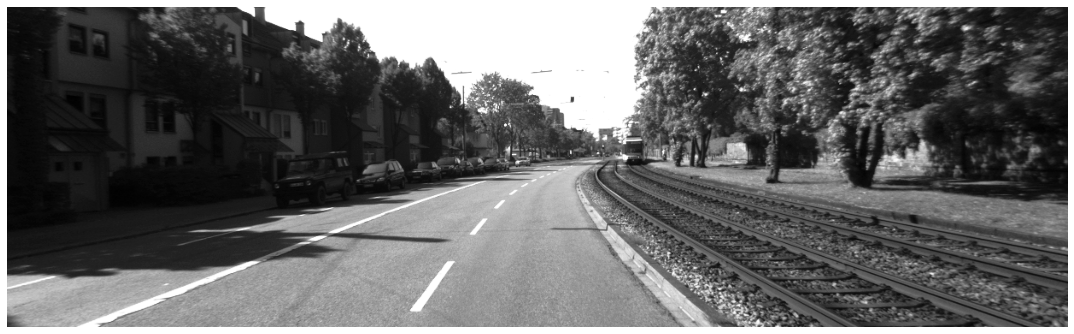

In [2]:
im = cv2.imread('data-cache/2011_09_26/2011_09_26_drive_0001_sync/image_00/data/0000000000.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(19, 19))
plt.imshow(im, 'Greys_r')
plt.axis('off')

In [3]:
with open('data-cache/2011_09_26/calib_cam_to_cam.txt', 'r') as f:
    lines = {p[0] : p[2].strip() for p in list(map(lambda l : l.partition(':'), [l for l in f.readlines()]))}
K = np.fromstring(lines['K_00'], sep=' ').reshape(3, 3)
print(K)

[[984.2439   0.     690.    ]
 [  0.     980.8141 233.1966]
 [  0.       0.       1.    ]]


In [4]:
with open('data-cache/2011_09_26/calib_velo_to_cam.txt', 'r') as f:
    lines = {p[0] : p[2].strip() for p in list(map(lambda l : l.partition(':'), [l for l in f.readlines()]))}
R_CV = np.fromstring(lines['R'], sep=' ').reshape(3, 3)
p_CV_C = np.fromstring(lines['T'], sep=' ')
print(np.rad2deg(transforms3d.euler.mat2euler(R_CV)))
print(p_CV_C)

[ 26.93535073 -89.04830974  63.02612693]
[-0.00406977 -0.07631618 -0.2717806 ]


In [6]:
def _rot(r_deg, p_deg, h_deg):
    return transforms3d.euler.euler2mat(*np.deg2rad([r_deg, p_deg, h_deg]))

# XXX Should get this from the pose messages...
R_OA = _rot(-93.5, 0.0, -90.0)
p_OA_O = np.array([-30.0, 0.0, 2.0])
print(np.rad2deg(transforms3d.euler.mat2euler(R_OA)))
print(p_OA_O)
print(R_OA)

R_OB = _rot(180.0, 0.0, -90.0)
p_OB_O = np.array([0.0, 0.0, 150.0])

R_BA = R_OB.T @ R_OA
p_BA_B = R_OB.T @ (-p_OB_O + p_OA_O)

# Plane normal (expressed in A frame) and distance to plane, 
# see [reference](https://mathworld.wolfram.com/Plane.html)
unit_Oz_O = np.array([0.0, 0.0, 1.0])
unit_Oz_A = R_OA.T @ unit_Oz_O
d = unit_Oz_A.dot(R_OA.T @ p_OA_O)

H_BA = K @ (R_BA - np.outer(p_BA_B, unit_Oz_A) / d) @ np.linalg.inv(K)
H_BA /= H_BA[2, 2]  # normalize
print(H_BA)

[-93.5   0.  -90. ]
[-30.   0.   2.]
[[ 6.12323400e-17 -6.10485395e-02  9.98134798e-01]
 [-1.00000000e+00 -3.73814493e-18  6.11181293e-17]
 [-0.00000000e+00 -9.98134798e-01 -6.10485395e-02]]
[[-7.56431661e-02 -3.98366260e+00  7.42193785e+02]
 [-0.00000000e+00 -2.48349191e+00  5.04489801e+02]
 [-0.00000000e+00 -5.77342406e-03  1.00000000e+00]]


[180.  -86.5 -90. ]
[1.83697020e-15 1.64813411e-01 3.00661410e+01]
[10.          1.3857842  10.10344506]


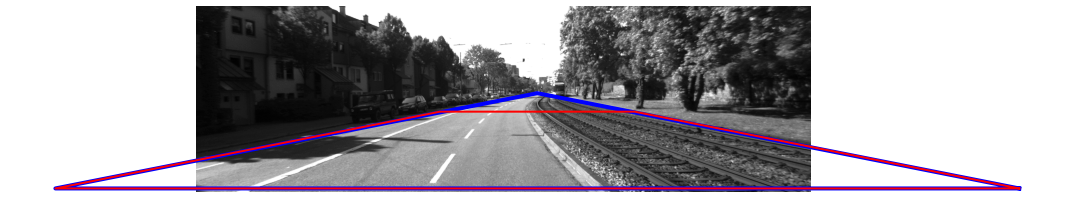

In [9]:
fig = plt.figure(figsize=(19, 9))
ax = fig.add_subplot(211)
ax.imshow(im, cmap='Greys_r')
ax.axis('off')

# Plot some points...
def _project(p):
    uv = K @ p
    uv /= uv[2]
    return uv

R_AO = R_OA.T
p_AO_A = -(R_AO @ p_OA_O)
print(np.rad2deg(transforms3d.euler.mat2euler(R_AO)))
print(p_AO_A)

# Some region in raw image
uvr0 = _project(R_AO @ np.array([-20, -10, 0]) + p_AO_A)
uvr1 = _project(R_AO @ np.array([-20,  10, 0]) + p_AO_A)
uvr2 = _project(R_AO @ np.array([ 20,  10, 0]) + p_AO_A)
uvr3 = _project(R_AO @ np.array([ 20, -10, 0]) + p_AO_A)
print(R_AO @ np.array([-20, -10, 0]) + p_AO_A)
uvr_corners = np.vstack((uvr0, uvr1, uvr2, uvr3, uvr0))

# Show 'point at infinity'
uvr4 = _project(R_AO @ np.array([1000, 0, 0]) + p_AO_A)
uvr_inf = np.vstack((uvr0, uvr1, uvr4, uvr0))

ax.plot(uvr_inf[:, 0], uvr_inf[:, 1], 'b-', lw=4)
ax.plot(uvr_corners[:, 0], uvr_corners[:, 1], 'r-', lw=2)

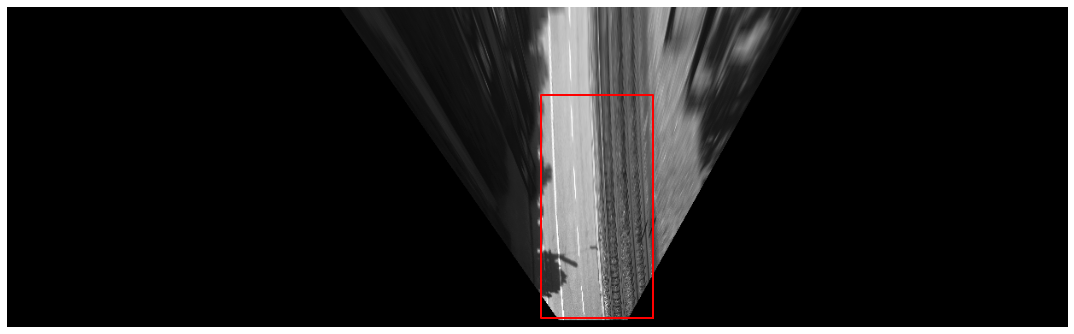

In [7]:
imw = cv2.warpPerspective(im, H_BA, dsize=(im.shape[1], im.shape[0]))

fig = plt.figure(figsize=(19, 9))
ax = fig.add_subplot(111)
ax.imshow(imw, cmap='Greys_r')
ax.axis('off')

def _warp(uvr):
    uvw = H_BA @ uvr
    uvw /= uvw[2]
    return uvw

# Some region in warped image
uvw_corners = np.vstack([_warp(uvr) for uvr in uvr_corners])
ax.plot(uvw_corners[:, 0], uvw_corners[:, 1], 'r-', lw=2)

(-0.5, 130.5, 260.5, -0.5)

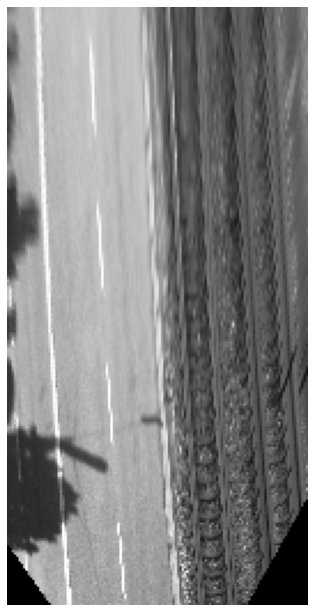

In [8]:
uvw_min = uvw_corners.min(axis=0).astype(np.int32)
uvw_max = uvw_corners.max(axis=0).astype(np.int32)

fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(111)
ax.imshow(imw[uvw_min[1]:uvw_max[1], uvw_min[0]:uvw_max[0]], cmap='Greys_r')
ax.axis('off')